Epoch 1/5


2023-02-27 14:40:24.068648: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1874/1875 [============================>.] - ETA: 0s - loss: 0.3802 - accuracy: 0.8608

2023-02-27 14:40:52.347742: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1875/1875 [==============================] - 31s 16ms/step - loss: 0.3801 - accuracy: 0.8608 - val_loss: 0.2884 - val_accuracy: 0.8935
Epoch 2/5
1875/1875 [==============================] - 30s 16ms/step - loss: 0.2371 - accuracy: 0.9133 - val_loss: 0.2523 - val_accuracy: 0.9117
Epoch 3/5
1875/1875 [==============================] - 30s 16ms/step - loss: 0.1878 - accuracy: 0.9300 - val_loss: 0.2323 - val_accuracy: 0.9187
Epoch 4/5
1875/1875 [==============================] - 30s 16ms/step - loss: 0.1472 - accuracy: 0.9454 - val_loss: 0.2289 - val_accuracy: 0.9178
Epoch 5/5
 28/313 [=>............................] - ETA: 1s

2023-02-27 14:42:54.498227: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - 2s 8ms/step


/var/folders/1t/sj3jytd91z53kgnkw3mqp59r0000gn/T/ipykernel_5425/3921652836.py:68: RuntimeWarning: invalid value encountered in divide
  channel_image /= channel_image.std()


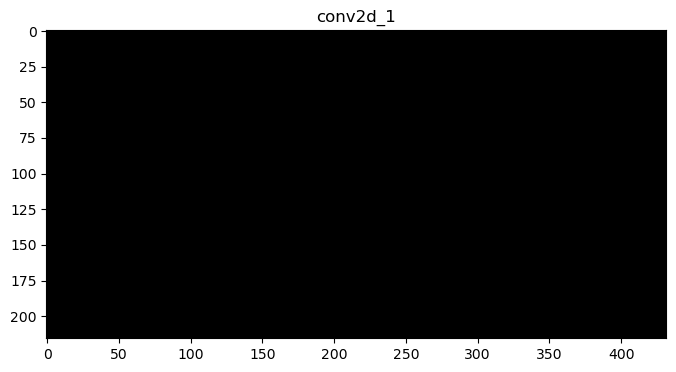

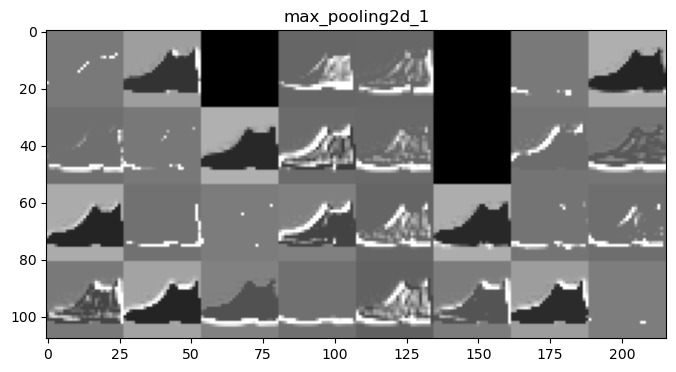

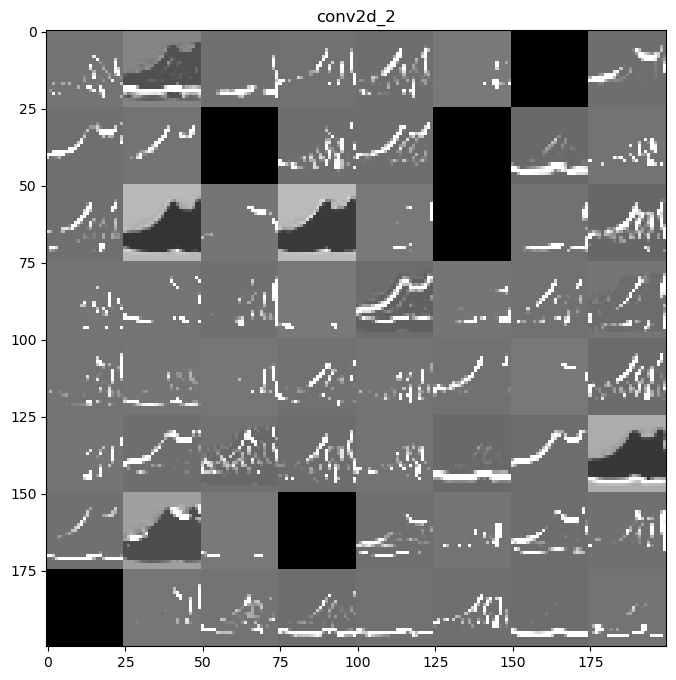

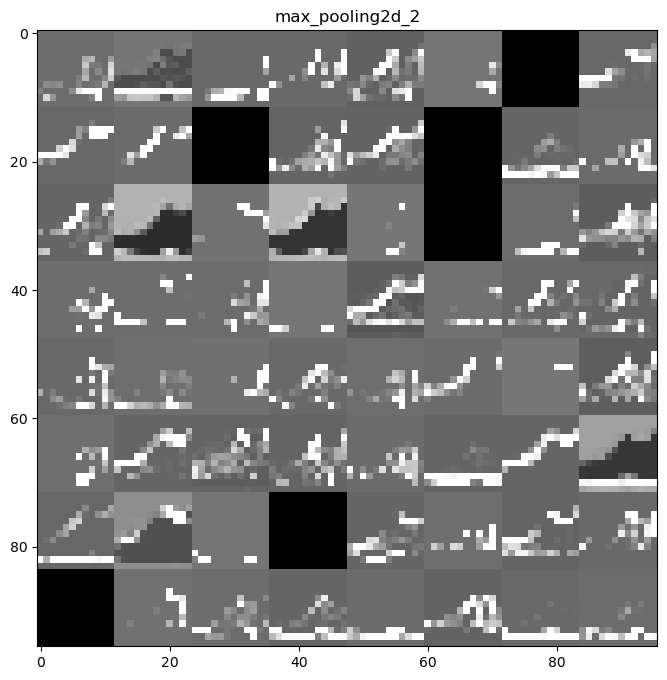

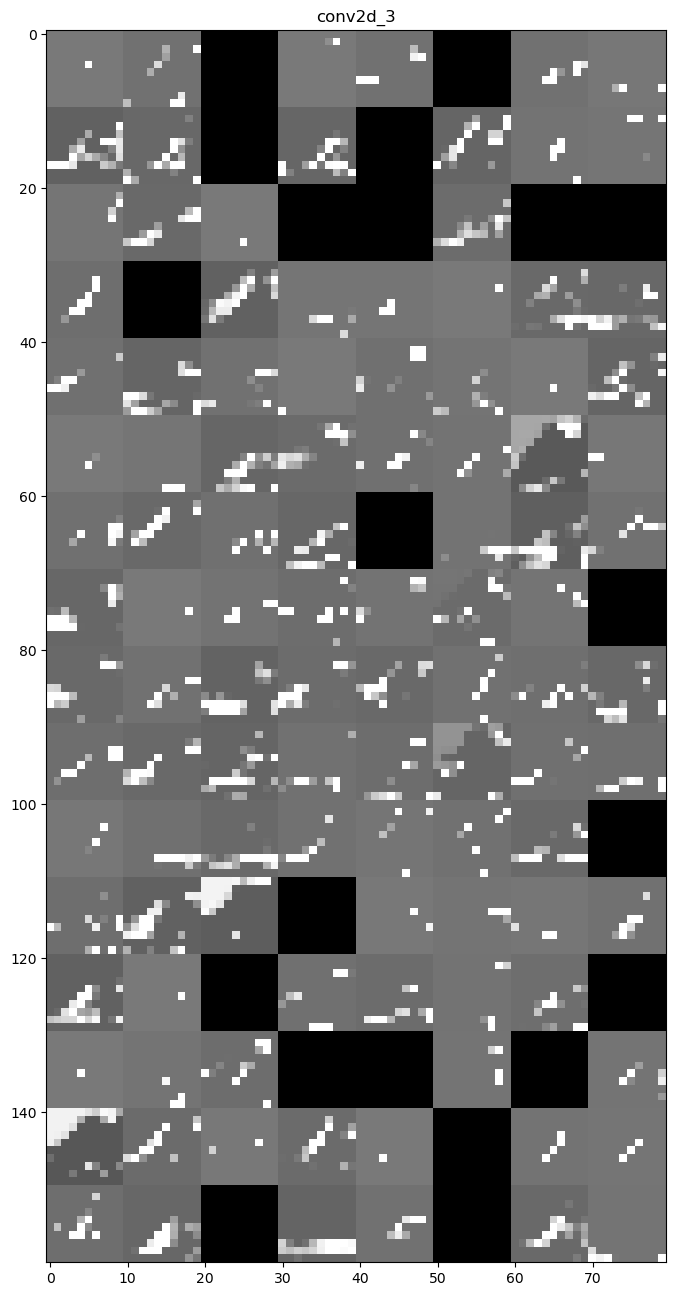

In [6]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Load and preprocess the dataset
fashion_mnist = tf.keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

# Resize images to 56x56
train_images_resized = np.zeros((train_images.shape[0], 56, 56), dtype=np.float32)
for i in range(train_images.shape[0]):
    img = Image.fromarray(train_images[i])
    img = img.resize((56, 56), resample=Image.BICUBIC)
    train_images_resized[i] = np.asarray(img)

test_images_resized = np.zeros((test_images.shape[0], 56, 56), dtype=np.float32)
for i in range(test_images.shape[0]):
    img = Image.fromarray(test_images[i])
    img = img.resize((56, 56), resample=Image.BICUBIC)
    test_images_resized[i] = np.asarray(img)

# Add channel dimension and scale pixel values to [0, 1]
train_images = np.expand_dims(train_images_resized, axis=-1) / 255.0
test_images = np.expand_dims(test_images_resized, axis=-1) / 255.0


# Define the CNN architecture
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(56, 56, 1), name='conv2d_1'),
    tf.keras.layers.MaxPooling2D((2, 2), name='max_pooling2d_1'),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', name='conv2d_2'),
    tf.keras.layers.MaxPooling2D((2, 2), name='max_pooling2d_2'),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', name='conv2d_3'),
    tf.keras.layers.Flatten(name='flatten'),
    tf.keras.layers.Dense(128, activation='relu', name='dense_1'),
    tf.keras.layers.Dense(10, activation='softmax', name='output')
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model and display the activations after each epoch

history = model.fit(train_images, train_labels, epochs=5, validation_data=(test_images, test_labels))

# Get the layer outputs and names
layer_names = ['conv2d_1', 'max_pooling2d_1', 'conv2d_2', 'max_pooling2d_2', 'conv2d_3']
layer_outputs = [layer.output for layer in model.layers if layer.name in layer_names]
activation_model = tf.keras.models.Model(inputs=model.input, outputs=layer_outputs)

# Get the activation outputs for the test images
activations = activation_model.predict(test_images)
# Display the activation outputs of the convolutional layers as images on a grid

# Display the activation outputs of the convolutional layers as images on a grid
for layer_name, layer_activation in zip(layer_names, activations):
    n_features = layer_activation.shape[-1]
    size = layer_activation.shape[1]
    n_cols = n_features // 8
    display_grid = np.zeros((size * n_cols, 8 * size))
    for col in range(n_cols):
        for row in range(8):
            channel_image = layer_activation[0, :, :, col * 8 + row]
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size:(col + 1) * size, row * size:(row + 1) * size] = channel_image
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1], scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect= 'auto',cmap='gray')    
plt.show()


In [36]:
class MyConv2D(tf.keras.layers.Layer):
    def __init__(self, filters, kernel_size, **kwargs):
        super(MyConv2D, self).__init__(**kwargs)
        self.filters = filters
        self.kernel_size = kernel_size
    
    def build(self, input_shape):
        self.kernel = self.add_weight(name='kernel',
                                      shape=(self.kernel_size, self.kernel_size, input_shape[-1], self.filters),
                                      initializer='glorot_uniform',
                                      trainable=True)
        super(MyConv2D, self).build(input_shape)
    
    def call(self, inputs):
        outputs = tf.nn.conv2d(inputs, self.kernel, strides=[1, 1, 1, 1], padding='SAME')
        outputs = tf.nn.relu(outputs)
        return outputs
    
    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[1], input_shape[2], self.filters)


model = tf.keras.models.Sequential([
    MyConv2D(32, 3, activation='relu', input_shape=(28, 28, 1), name='my_conv2d_1'),
    tf.keras.layers.MaxPooling2D((2, 2), name='max_pooling2d_1'),
    MyConv2D(64, 3, activation='relu', name='my_conv2d_2'),
    tf.keras.layers.MaxPooling2D((2, 2), name='max_pooling2d_2'),
    MyConv2D(128, 3, activation='relu', name='my_conv2d_3'),
    tf.keras.layers.Flatten(name='flatten'),
    tf.keras.layers.Dense(128, activation='relu', name='dense_1'),
    tf.keras.layers.Dense(10, activation='softmax', name='output')
])

TypeError: ('Keyword argument not understood:', 'activation')